# Fine-Tuning Stable Diffusion XL for Naruto Art Style

## 📋 Assignment Overview

**Objective**: Fine-tune SDXL base model to generate images in Naruto anime art style

**Hardware Constraint**: Google Colab T4 GPU (~16GB VRAM)

**The Challenge**: SDXL is a massive model (~6.6B parameters) that cannot be trained on a T4 GPU using standard methods. We need advanced optimization techniques.


## 🎯 My Strategy: Memory-Efficient Training

### Why Standard Training Fails:
- **SDXL Model Size**: ~6.6B parameters = ~13GB in FP16
- **Activation Memory**: Forward pass at 1024x1024 = ~8GB
- **Optimizer States**: Adam needs 2x model size = ~26GB
- **Gradients**: Another ~13GB
- **Total**: ~60GB VRAM needed ❌

### My Solutions:

| Technique | Memory Saved | Trade-off |
|-----------|--------------|-----------|
| **LoRA** | ~99% params frozen | Slight quality reduction |
| **Lower Resolution** (512px) | 4x reduction | Can upscale later |
| **Gradient Checkpointing** | ~30% activation memory | 20% slower training |
| **8-bit Adam** | 75% optimizer memory | Minimal impact |
| **Mixed Precision (FP16)** | 50% model memory | Handled by accelerate |
| **xFormers** | 30% attention memory | None! |
| **Batch Size 1 + Gradient Accumulation** | Linear memory scaling | Same effective batch size |

### Expected Total VRAM Usage: ~12-14GB ✅


## 🔧 Part 1: Environment Setup


### 1.1 Handle NumPy Version Compatibility


In [ ]:
# Install specific NumPy version required for compatibility
!pip install numpy==1.26.4 -q

import numpy as np
print(f"NumPy Version: {np.__version__}")

# Force reload if version mismatch (Colab sometimes auto-updates)
if int(np.__version__[0]) > 1:
    print("⚠️ Warning: NumPy version mismatch detected")
    print("Reloading session with correct version...")
    import os
    os.kill(os.getpid(), 9)


NumPy Version: 1.26.4


### 1.2 Mount Google Drive for Saving Outputs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("✓ Google Drive mounted successfully")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully


### 1.3 Setup Directory Structure


In [ ]:
import os

# Define all paths
root_dir = "/content"
drive_dir = "/content/drive/MyDrive"
training_dir = "/content/LoRA"
pretrained_model = "/content/pretrained_model"
vae_dir = "/content/vae"
output_dir = "/content/drive/MyDrive/sdxl-naruto-lora"
config_dir = os.path.join(training_dir, "config")

# Create directories
for dir_path in [training_dir, config_dir, pretrained_model, vae_dir, output_dir]:
    os.makedirs(dir_path, exist_ok=True)
    print(f"✓ Created: {dir_path}")


✓ Created: /content/LoRA
✓ Created: /content/LoRA/config
✓ Created: /content/pretrained_model
✓ Created: /content/vae
✓ Created: /content/drive/MyDrive/sdxl-naruto-lora


## 📦 Part 2: Install Dependencies

### Strategy: Careful Version Management

We need compatible versions of:
- **PyTorch 2.4.0** with CUDA 11.8
- **xFormers 0.0.27** (memory-efficient attention)
- **Diffusers 0.25.0** (SDXL support)
- **PEFT 0.7.1** (LoRA implementation)
- **bitsandbytes 0.41.0** (8-bit optimizer)


### 2.1 Remove Conflicting Packages


In [ ]:
!pip uninstall -y torch torchvision torchaudio xformers transformers diffusers accelerate -q

print("✓ Removed conflicting packages")


✓ Removed conflicting packages


### 2.2 Install PyTorch with CUDA 11.8


In [ ]:
!pip install torch==2.4.0+cu118 torchvision==0.19.0+cu118 --index-url https://download.pytorch.org/whl/cu118 -q

print("✓ PyTorch 2.4.0 + CUDA 11.8 installed")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.7.1 requires accelerate>=0.21.0, which is not installed.
peft 0.7.1 requires transformers, which is not installed.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, which is not installed.
✓ PyTorch 2.4.0 + CUDA 11.8 installed


### 2.3 Install xFormers (Memory-Efficient Attention)

**Why xFormers?**
- Standard attention: O(n²) memory complexity
- xFormers: O(n) memory with Flash Attention
- ~30% memory reduction for attention layers


In [ ]:
!pip install xformers==0.0.27.post2+cu118 --index-url https://download.pytorch.org/whl/cu118 -q

print("✓ xFormers installed")


✓ xFormers installed


### 2.4 Install HuggingFace Ecosystem


In [ ]:
!pip install \
    transformers==4.36.0 \
    diffusers==0.25.0 \
    accelerate==0.25.0 \
    datasets==2.16.0 \
    huggingface-hub==0.20.0 \
    peft==0.7.1 \
    safetensors==0.4.1 \
    bitsandbytes==0.41.0 -q

print("✓ HuggingFace packages installed")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.0 which is incompatible.
✓ HuggingFace packages installed


### 2.5 Install Additional Dependencies


In [ ]:
!pip install pillow requests tqdm omegaconf pytorch-lightning einops -q

print("✓ Additional dependencies installed")


✓ Additional dependencies installed


### 2.6 Verify Installation


In [ ]:
import torch
import diffusers
import transformers
import peft
import xformers

print("=" * 70)
print("INSTALLED VERSIONS:")
print("=" * 70)
print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ Diffusers: {diffusers.__version__}")
print(f"✓ Transformers: {transformers.__version__}")
print(f"✓ PEFT: {peft.__version__}")
print(f"✓ xFormers: {xformers.__version__}")
print(f"✓ CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    vram_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✓ VRAM: {vram_gb:.2f} GB")

    if vram_gb < 15:
        print("⚠️  Warning: Less than 16GB VRAM detected")
        print("   Training may be tight on memory. Consider:")
        print("   - Reducing batch size")
        print("   - Using resolution 384 instead of 512")
else:
    print("❌ CUDA not available!")

print("=" * 70)


/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


INSTALLED VERSIONS:
✓ PyTorch: 2.4.0+cu118
✓ Diffusers: 0.25.0
✓ Transformers: 4.36.0
✓ PEFT: 0.7.1
✓ xFormers: 0.0.27.post2+cu118
✓ CUDA Available: True
✓ GPU: Tesla T4
✓ VRAM: 15.83 GB


## 📊 Part 3: Dataset Preparation

### Dataset: Naruto BLIP Captions
- **Source**: HuggingFace `lambdalabs/naruto-blip-captions`
- **Size**: ~1000+ images
- **Format**: Images with BLIP-generated captions

**Why BLIP Captions?**
- BLIP (Bootstrapping Language-Image Pre-training) generates descriptive captions
- Better than filenames or manual captions
- Helps model learn Naruto-specific features


### 3.1 Download Dataset


In [ ]:
from datasets import load_dataset
from PIL import Image
from tqdm.auto import tqdm

print("Downloading Naruto dataset...")

# Download from HuggingFace
dataset = load_dataset("lambdalabs/naruto-blip-captions", split="train")

print(f"✓ Loaded {len(dataset)} images")
print(f"✓ Dataset size: ~{len(dataset)} training examples")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/_login.py:337: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/_login.py:337: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

✓ Loaded 1221 images
✓ Dataset size: ~1221 training examples


/usr/local/lib/python3.12/dist-packages/huggingface_hub/_login.py:337: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


✓ Loaded 1221 images
✓ Dataset size: ~1221 training examples


### 3.2 Prepare Training Directory


In [ ]:
train_data_dir = "/content/naruto_train"
os.makedirs(train_data_dir, exist_ok=True)

print(f"✓ Training data directory: {train_data_dir}")


✓ Training data directory: /content/naruto_train


### 3.3 Save Images and Captions

**Format**: Each image gets:
- `00001.jpg` - The image file
- `00001.txt` - The caption file


In [ ]:
print("Processing dataset...")
print("Saving images and captions...")

for idx in tqdm(range(len(dataset)), desc="Processing"):
    item = dataset[idx]

    # Save image (convert to RGB, save as JPEG)
    img = item["image"].convert("RGB")
    img_path = f"{train_data_dir}/{idx:05d}.jpg"
    img.save(img_path, quality=95)

    # Save caption
    caption = item["text"]
    caption_path = f"{train_data_dir}/{idx:05d}.txt"
    with open(caption_path, "w", encoding="utf-8") as f:
        f.write(caption)

print(f"✓ Dataset prepared in {train_data_dir}")
print(f"✓ Total files: {len(dataset) * 2} (images + captions)")

# Display a sample
sample_idx = 0
sample_img = Image.open(f"{train_data_dir}/{sample_idx:05d}.jpg")
with open(f"{train_data_dir}/{sample_idx:05d}.txt", "r") as f:
    sample_caption = f.read()

print(f"\n📝 Sample caption: {sample_caption}")


Processing dataset...
Saving images and captions...


Processing:   0%|          | 0/1221 [00:00<?, ?it/s]

✓ Dataset prepared in /content/naruto_train
✓ Total files: 2442 (images + captions)

📝 Sample caption: a man with dark hair and brown eyes


## 🏗️ Part 4: Model Architecture & Configuration

### SDXL Architecture Overview:

```
SDXL Pipeline
├── Text Encoder 1 (OpenCLIP ViT-L)    - 123M params
├── Text Encoder 2 (OpenCLIP ViT-bigG) - 695M params
├── UNet (Diffusion Model)             - 2.6B params ← We train this!
└── VAE (Image Encoder/Decoder)        - 83M params
```

### Why LoRA on UNet?
- UNet is the "artist" - it learns to denoise images
- Text encoders understand language (already good)
- VAE handles image encoding/decoding (already good)
- **LoRA**: Only train small adapter matrices instead of full UNet


### 4.1 Import Required Libraries


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from diffusers import (
    StableDiffusionXLPipeline,
    UNet2DConditionModel,
    AutoencoderKL,
    DDPMScheduler,
)
from transformers import CLIPTextModel, CLIPTextModelWithProjection, CLIPTokenizer
from peft import LoraConfig, get_peft_model
from accelerate import Accelerator
from tqdm.auto import tqdm
import glob
import random
from PIL import Image
import numpy as np

print("✓ All training libraries imported")


/usr/local/lib/python3.12/dist-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")


✓ All training libraries imported


/usr/local/lib/python3.12/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/usr/local/lib/python3.12/dist-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


### 4.2 Training Configuration

**Key Parameters Explained:**

| Parameter | Value | Why? |
|-----------|-------|------|
| `resolution` | 512 | 4x less memory than 1024, still good quality |
| `train_batch_size` | 1 | Minimum for T4, use grad accumulation |
| `gradient_accumulation_steps` | 4 | Effective batch size = 4 |
| `learning_rate` | 1e-5 | Standard for LoRA training |
| `lora_rank` | 32 | Balance between quality and memory |
| `lora_alpha` | 16 | Scaling factor (usually rank/2) |
| `mixed_precision` | "fp16" | 50% memory reduction |
| `use_xformers` | True | 30% attention memory reduction |
| `gradient_checkpointing` | True | 30% activation memory reduction |
| `use_8bit_adam` | True | 75% optimizer memory reduction |


In [ ]:
class TrainingConfig:
    """Configuration for SDXL LoRA fine-tuning on T4 GPU"""

    # ==================== Model ====================
    model_id = "stabilityai/stable-diffusion-xl-base-1.0"

    # ==================== Dataset ====================
    train_data_dir = train_data_dir
    resolution = 512  # REDUCED from 1024 (4x memory saving)

    # ==================== Training Hyperparameters ====================
    num_epochs = 5
    train_batch_size = 1  # MINIMUM for T4
    gradient_accumulation_steps = 4  # Effective batch size = 4
    learning_rate = 1e-5
    mixed_precision = "fp16"  # 50% memory reduction

    # ==================== LoRA Configuration ====================
    lora_rank = 32  # Number of LoRA dimensions
    lora_alpha = 16  # LoRA scaling factor
    lora_dropout = 0.1  # Regularization

    # ==================== Memory Optimizations ====================
    use_xformers = True  # Flash Attention (30% memory saving)
    gradient_checkpointing = True  # Trade compute for memory (30% saving)
    use_8bit_adam = True  # 8-bit optimizer (75% optimizer memory saving)

    # ==================== Checkpointing ====================
    output_dir = output_dir
    save_steps = 500  # Save every 500 steps
    save_epochs = 1

    # ==================== Validation ====================
    validation_prompts = [
        "Naruto Uzumaki eating ramen, anime style",
        "Bill Gates in Naruto anime style",
        "A boy with blue eyes in Naruto style",
    ]

    # ==================== Other ====================
    seed = 42
    max_grad_norm = 1.0  # Gradient clipping

    # ==================== SDXL Specific ====================
    vae_scale_factor = 0.13025  # CRITICAL: SDXL VAE scaling factor

config = TrainingConfig()

print("✓ Training configuration loaded")
print(f"\n📊 Key Settings:")
print(f"  • Resolution: {config.resolution}x{config.resolution}")
print(f"  • Batch Size: {config.train_batch_size}")
print(f"  • Gradient Accumulation: {config.gradient_accumulation_steps}")
print(f"  • Effective Batch Size: {config.train_batch_size * config.gradient_accumulation_steps}")
print(f"  • LoRA Rank: {config.lora_rank}")
print(f"  • Learning Rate: {config.learning_rate}")
print(f"  • Epochs: {config.num_epochs}")


✓ Training configuration loaded

📊 Key Settings:
  • Resolution: 512x512
  • Batch Size: 1
  • Gradient Accumulation: 4
  • Effective Batch Size: 4
  • LoRA Rank: 32
  • Learning Rate: 1e-05
  • Epochs: 5


### 4.3 Custom Dataset Class

**What it does:**
1. Loads images from disk
2. Applies transforms (resize, crop, normalize)
3. Loads corresponding text captions
4. Returns batches for training


In [ ]:
class NarutoDataset(Dataset):
    """Custom Dataset for Naruto images and captions"""

    def __init__(self, data_dir, resolution=512):
        self.data_dir = data_dir
        self.resolution = resolution

        # Find all images
        self.image_paths = sorted(glob.glob(f"{data_dir}/*.jpg"))
        print(f"Found {len(self.image_paths)} training images")

        # Image transforms
        from torchvision import transforms
        self.transforms = transforms.Compose([
            transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),  # Normalize to [-1, 1]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.transforms(image)

        # Load caption
        caption_path = img_path.replace(".jpg", ".txt")
        try:
            with open(caption_path, "r", encoding="utf-8") as f:
                caption = f.read().strip()
        except:
            caption = "anime style artwork"  # Fallback

        return {
            "pixel_values": pixel_values,
            "caption": caption,
        }

print("✓ Dataset class defined")


✓ Dataset class defined


## 🚀 Part 5: Model Setup

### Critical Memory Management Strategy:

**Dtype Management** (Most Important!):
- **VAE**: `float32` - Encoding requires precision to avoid NaN
- **UNet**: `float32` - Training requires full precision (accelerator handles FP16)
- **Text Encoders**: `float16` - Frozen, can use lower precision
- **Prompt Embeddings**: Convert to `float32` before UNet (xFormers requirement)

This solves the common "NaN loss" and "dtype mismatch" errors!


### 5.1 Setup Function


In [ ]:
def setup_training():
    """Initialize all models and training components"""

    # ==================== Set Random Seeds ====================
    torch.manual_seed(config.seed)
    random.seed(config.seed)
    np.random.seed(config.seed)
    print("✓ Random seeds set")

    # ==================== Initialize Accelerator ====================
    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        mixed_precision=config.mixed_precision,
    )

    print(f"\n{'='*70}")
    print("ACCELERATOR INFO:")
    print(f"{'='*70}")
    print(f"✓ Device: {accelerator.device}")
    print(f"✓ Mixed Precision: {config.mixed_precision}")
    print(f"✓ Distributed: {accelerator.num_processes > 1}")
    print(f"✓ Gradient Accumulation: {config.gradient_accumulation_steps} steps")
    print(f"{'='*70}\n")

    # ==================== Load VAE ====================
    print("Loading VAE...")
    vae = AutoencoderKL.from_pretrained(
        config.model_id,
        subfolder="vae",
        torch_dtype=torch.float32  # CRITICAL: Keep in float32 for stability
    )
    vae.requires_grad_(False)  # Freeze VAE
    vae.enable_slicing()  # Memory optimization
    vae.enable_tiling()  # Memory optimization
    print("✓ VAE loaded (float32, frozen)")

    # ==================== Load Text Encoders ====================
    print("\nLoading text encoders...")

    # Text Encoder 1 (OpenCLIP ViT-L)
    text_encoder_one = CLIPTextModel.from_pretrained(
        config.model_id,
        subfolder="text_encoder",
        torch_dtype=torch.float16  # Can use FP16 (frozen)
    )
    text_encoder_one.requires_grad_(False)

    # Text Encoder 2 (OpenCLIP ViT-bigG)
    text_encoder_two = CLIPTextModelWithProjection.from_pretrained(
        config.model_id,
        subfolder="text_encoder_2",
        torch_dtype=torch.float16  # Can use FP16 (frozen)
    )
    text_encoder_two.requires_grad_(False)
    print("✓ Text encoders loaded (float16, frozen)")

    # ==================== Load Tokenizers ====================
    print("\nLoading tokenizers...")
    tokenizer_one = CLIPTokenizer.from_pretrained(
        config.model_id,
        subfolder="tokenizer"
    )
    tokenizer_two = CLIPTokenizer.from_pretrained(
        config.model_id,
        subfolder="tokenizer_2"
    )
    print("✓ Tokenizers loaded")

    # ==================== Load UNet ====================
    print("\nLoading UNet...")
    unet = UNet2DConditionModel.from_pretrained(
        config.model_id,
        subfolder="unet",
        torch_dtype=torch.float32  # CRITICAL: Keep in float32 for training
    )
    print("✓ UNet loaded (float32, trainable)")

    # ==================== Apply Memory Optimizations ====================
    print("\nApplying memory optimizations...")

    # xFormers (Flash Attention)
    if config.use_xformers:
        try:
            unet.enable_xformers_memory_efficient_attention()
            print("✓ xFormers enabled (30% attention memory saved)")
        except Exception as e:
            print(f"⚠️  xFormers failed: {e}")
            print("   Using standard attention instead")

    # Gradient Checkpointing
    if config.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        print("✓ Gradient checkpointing enabled (30% activation memory saved)")

    # ==================== Apply LoRA ====================
    print("\nApplying LoRA to UNet...")

    lora_config = LoraConfig(
        r=config.lora_rank,  # Rank of LoRA matrices
        lora_alpha=config.lora_alpha,  # Scaling factor
        init_lora_weights="gaussian",  # Initialization
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],  # Which layers to adapt
        lora_dropout=config.lora_dropout,  # Regularization
    )

    unet = get_peft_model(unet, lora_config)
    unet.print_trainable_parameters()

    # ==================== Load Noise Scheduler ====================
    print("\nLoading noise scheduler...")
    noise_scheduler = DDPMScheduler.from_pretrained(
        config.model_id,
        subfolder="scheduler"
    )
    print("✓ Scheduler loaded")

    # ==================== Create Dataset & DataLoader ====================
    print("\nPreparing dataset...")
    dataset = NarutoDataset(config.train_data_dir, config.resolution)
    dataloader = DataLoader(
        dataset,
        batch_size=config.train_batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )
    print(f"✓ DataLoader created ({len(dataloader)} batches)")

    # ==================== Setup Optimizer ====================
    print("\nSetting up optimizer...")

    if config.use_8bit_adam:
        try:
            import bitsandbytes as bnb
            optimizer = bnb.optim.AdamW8bit(
                unet.parameters(),
                lr=config.learning_rate,
                betas=(0.9, 0.999),
                weight_decay=1e-2,
                eps=1e-8,
            )
            print("✓ Using 8-bit AdamW (75% optimizer memory saved)")
        except Exception as e:
            print(f"⚠️  8-bit optimizer failed: {e}")
            optimizer = torch.optim.AdamW(
                unet.parameters(),
                lr=config.learning_rate,
                betas=(0.9, 0.999),
                weight_decay=1e-2,
                eps=1e-8,
            )
            print("✓ Using standard AdamW")
    else:
        optimizer = torch.optim.AdamW(
            unet.parameters(),
            lr=config.learning_rate,
            betas=(0.9, 0.999),
            weight_decay=1e-2,
            eps=1e-8,
        )
        print("✓ Using standard AdamW")

    # ==================== Prepare with Accelerator ====================
    print("\nPreparing models with Accelerator...")
    unet, optimizer, dataloader = accelerator.prepare(
        unet, optimizer, dataloader
    )

    # Move frozen models to device
    vae = vae.to(accelerator.device, dtype=torch.float32)
    text_encoder_one = text_encoder_one.to(accelerator.device, dtype=torch.float16)
    text_encoder_two = text_encoder_two.to(accelerator.device, dtype=torch.float16)

    print("✓ All models prepared and moved to device")

    return (
        accelerator, unet, vae, text_encoder_one, text_encoder_two,
        tokenizer_one, tokenizer_two, noise_scheduler, dataloader, optimizer
    )

print("✓ Setup function defined")


✓ Setup function defined


## 📝 Part 6: Prompt Encoding

### SDXL's Dual Text Encoder Architecture:

SDXL uses **two text encoders** for better text understanding:
1. **OpenCLIP ViT-L** (123M params) - Broader understanding
2. **OpenCLIP ViT-bigG** (695M params) - Detailed understanding

The embeddings are concatenated and pooled for the UNet.


In [ ]:
def encode_prompt(
    text_encoder_one, text_encoder_two,
    tokenizer_one, tokenizer_two,
    prompt, device
):
    """
    Encode text prompt using SDXL's dual text encoders

    Returns:
        prompt_embeds: Concatenated embeddings from both encoders
        pooled_prompt_embeds: Pooled embeddings for conditioning
    """

    # Tokenize with first tokenizer
    text_inputs_one = tokenizer_one(
        prompt,
        padding="max_length",
        max_length=tokenizer_one.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    # Tokenize with second tokenizer
    text_inputs_two = tokenizer_two(
        prompt,
        padding="max_length",
        max_length=tokenizer_two.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    # Encode with both encoders (no gradients needed)
    with torch.no_grad():
        # First encoder
        prompt_embeds_one = text_encoder_one(
            text_inputs_one.input_ids.to(device),
            output_hidden_states=True,
        )
        prompt_embeds_one = prompt_embeds_one.hidden_states[-2]  # Penultimate layer

        # Second encoder
        prompt_embeds_two = text_encoder_two(
            text_inputs_two.input_ids.to(device),
            output_hidden_states=True,
        )
        prompt_embeds_two_hidden = prompt_embeds_two.hidden_states[-2]
        pooled_prompt_embeds = prompt_embeds_two.text_embeds  # Pooled embeddings

    # Concatenate embeddings from both encoders
    prompt_embeds = torch.cat([prompt_embeds_one, prompt_embeds_two_hidden], dim=-1)

    return prompt_embeds, pooled_prompt_embeds

print("✓ Prompt encoding function defined")


✓ Prompt encoding function defined


## 🎓 Part 7: Training Loop

### Training Process (Diffusion Model):

1. **Forward Diffusion**: Add noise to real images
   ```
   clean_image -> noisy_image (at timestep t)
   ```

2. **UNet Prediction**: Model predicts the noise
   ```
   UNet(noisy_image, timestep, text_prompt) -> predicted_noise
   ```

3. **Loss Calculation**: Compare predicted vs actual noise
   ```
   loss = MSE(predicted_noise, actual_noise)
   ```

4. **Backpropagation**: Update LoRA weights only

### Key Fixes for NaN Loss:
- ✅ VAE in float32 with correct scaling factor (0.13025)
- ✅ Prompt embeddings converted to float32 before UNet
- ✅ All inputs to UNet in float32 (xFormers requirement)
- ✅ Gradient clipping to prevent exploding gradients
- ✅ NaN detection and batch skipping


In [ ]:
def train():
    """Main training loop"""

    print("\n" + "="*80)
    print("STARTING TRAINING")
    print("="*80 + "\n")

    # ==================== Setup ====================
    (
        accelerator, unet, vae, text_encoder_one, text_encoder_two,
        tokenizer_one, tokenizer_two, noise_scheduler, dataloader, optimizer
    ) = setup_training()

    # Training state
    global_step = 0
    total_loss = 0

    # ==================== Training Loop ====================
    for epoch in range(config.num_epochs):
        unet.train()
        epoch_loss = 0

        progress_bar = tqdm(
            total=len(dataloader),
            desc=f"Epoch {epoch+1}/{config.num_epochs}",
            disable=not accelerator.is_local_main_process
        )

        for step, batch in enumerate(dataloader):
            with accelerator.accumulate(unet):
                # ==================== Prepare Images ====================
                # Get pixel values in float32 for VAE
                pixel_values = batch["pixel_values"].to(
                    accelerator.device,
                    dtype=torch.float32
                )

                # ==================== Encode to Latents ====================
                # VAE encodes images to latent space (compressed representation)
                with torch.no_grad():
                    latents = vae.encode(pixel_values).latent_dist.sample()
                    # CRITICAL: Apply SDXL VAE scaling factor
                    latents = latents * config.vae_scale_factor

                # ==================== Add Noise (Forward Diffusion) ====================
                # Sample random noise
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]

                # Sample random timesteps for each image in batch
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=latents.device
                ).long()

                # Add noise to latents according to timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # ==================== Encode Text Prompts ====================
                captions = batch["caption"]
                prompt_embeds, pooled_prompt_embeds = encode_prompt(
                    text_encoder_one, text_encoder_two,
                    tokenizer_one, tokenizer_two,
                    captions, accelerator.device
                )

                # CRITICAL: Convert embeddings to float32 for xFormers compatibility
                prompt_embeds = prompt_embeds.to(dtype=torch.float32)
                pooled_prompt_embeds = pooled_prompt_embeds.to(dtype=torch.float32)

                # ==================== Prepare SDXL Conditioning ====================
                # SDXL requires additional time embeddings for conditioning
                add_time_ids = torch.tensor(
                    [[config.resolution, config.resolution, 0, 0, config.resolution, config.resolution]] * bsz,
                    dtype=torch.float32
                ).to(accelerator.device)

                # ==================== UNet Forward Pass ====================
                # Predict the noise residual
                added_cond_kwargs = {
                    "text_embeds": pooled_prompt_embeds,
                    "time_ids": add_time_ids
                }

                model_pred = unet(
                    noisy_latents,
                    timesteps,
                    encoder_hidden_states=prompt_embeds,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]

                # ==================== Calculate Loss ====================
                # Get target based on prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise  # Predict the noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                # MSE loss between predicted and actual noise
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                # ==================== NaN Detection ====================
                if torch.isnan(loss) or torch.isinf(loss):
                    # print(f"\n⚠️  WARNING: NaN/Inf loss detected at step {global_step}")
                    # print(f"   Skipping this batch...")
                    optimizer.zero_grad()
                    continue

                # ==================== Backpropagation ====================
                accelerator.backward(loss)

                # Clip gradients to prevent exploding gradients
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), config.max_grad_norm)

                # Update weights
                optimizer.step()
                optimizer.zero_grad()

            # ==================== Update Progress ====================
            if accelerator.sync_gradients:
                global_step += 1
                epoch_loss += loss.detach().item()
                total_loss += loss.detach().item()

                # Save checkpoint every N steps
                if global_step % config.save_steps == 0:
                    save_path = os.path.join(config.output_dir, f"checkpoint-{global_step}")
                    os.makedirs(save_path, exist_ok=True)

                    unwrapped_unet = accelerator.unwrap_model(unet)
                    unwrapped_unet.save_pretrained(save_path)

                    # Save training state
                    avg_loss_so_far = total_loss / global_step
                    with open(os.path.join(save_path, "training_state.txt"), "w") as f:
                        f.write(f"Step: {global_step}\n")
                        f.write(f"Epoch: {epoch+1}\n")
                        f.write(f"Average Loss: {avg_loss_so_far:.6f}\n")
                        f.write(f"Current Loss: {loss.detach().item():.6f}\n")

                    print(f"\n✓ Checkpoint saved: {save_path}")
                    print(f"  Step: {global_step}, Avg Loss: {avg_loss_so_far:.6f}")

            # Update progress bar
            logs = {
                "loss": loss.detach().item(),
                "step": global_step,
            }
            progress_bar.set_postfix(**logs)
            progress_bar.update(1)

        progress_bar.close()

        # ==================== Epoch Summary ====================
        avg_loss = epoch_loss / len(dataloader)
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{config.num_epochs} completed")
        print(f"Average loss: {avg_loss:.6f}")
        print(f"{'='*60}\n")

        # Save at epoch intervals
        if (epoch + 1) % config.save_epochs == 0:
            save_path = os.path.join(config.output_dir, f"epoch-{epoch+1}")
            os.makedirs(save_path, exist_ok=True)

            unwrapped_unet = accelerator.unwrap_model(unet)
            unwrapped_unet.save_pretrained(save_path)

            # Save epoch state
            with open(os.path.join(save_path, "epoch_state.txt"), "w") as f:
                f.write(f"Epoch: {epoch+1}/{config.num_epochs}\n")
                f.write(f"Total Steps: {global_step}\n")
                f.write(f"Epoch Average Loss: {avg_loss:.6f}\n")
                f.write(f"Overall Average Loss: {total_loss/global_step:.6f}\n")

            print(f"✓ Epoch checkpoint saved: {save_path}")

    # ==================== Save Final Model ====================
    print("\n" + "="*80)
    print("TRAINING COMPLETE! Saving final model...")
    print("="*80 + "\n")

    final_path = os.path.join(config.output_dir, "final_lora")
    os.makedirs(final_path, exist_ok=True)

    unwrapped_unet = accelerator.unwrap_model(unet)
    unwrapped_unet.save_pretrained(final_path)

    final_avg_loss = total_loss / global_step

    print(f"✓ Final LoRA weights saved to: {final_path}")
    print(f"✓ Final Average Loss: {final_avg_loss:.6f}")

    # ==================== Create Training Summary ====================
    summary = f"""# Training Complete! 🎉

## 📊 Training Statistics

**Output Directory:** `{config.output_dir}`
**Final Average Loss:** `{final_avg_loss:.6f}`
**Total Steps:** `{global_step}`
**Epochs Completed:** `{config.num_epochs}`

## 🔧 Optimization Techniques Applied

| Technique | Memory Saved | Impact |
|-----------|--------------|--------|
| LoRA (rank={config.lora_rank}) | ~99% params frozen | Only ~1% of UNet trained |
| Resolution 512x512 | 75% (vs 1024x1024) | 4x memory reduction |
| Gradient Checkpointing | ~30% | Activation memory |
| 8-bit AdamW | ~75% | Optimizer state memory |
| xFormers | ~30% | Attention memory |
| Mixed Precision FP16 | ~50% | Model memory |
| Batch Size 1 + Grad Accum 4 | Linear scaling | Effective batch size 4 |

**Estimated VRAM Usage:** ~12-14GB ✅ (Fits in T4 16GB)

## 🚀 How to Use Your Model

### Method 1: Load with PEFT

```python
import torch
from diffusers import StableDiffusionXLPipeline
from peft import PeftModel

# Load base pipeline
pipeline = StableDiffusionXLPipeline.from_pretrained(
    "{config.model_id}",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
).to("cuda")

# Load LoRA weights
pipeline.unet = PeftModel.from_pretrained(
    pipeline.unet,
    "{final_path}"
)

# Generate image
prompt = "Naruto Uzumaki eating ramen, anime style, highly detailed"
image = pipeline(
    prompt,
    num_inference_steps=30,
    guidance_scale=7.5
).images[0]

image.save("naruto_output.png")
```

### Method 2: Merge LoRA into Base Model

```python
# Merge LoRA weights into base model for faster inference
pipeline.unet = pipeline.unet.merge_and_unload()

# Now you can use it like a regular pipeline
image = pipeline(prompt).images[0]
```

## 📝 Training Prompts Used

{chr(10).join([f"- {p}" for p in config.validation_prompts])}

## 🎯 Next Steps

1. **Test with validation prompts** to see if style was learned
2. **Experiment with inference parameters**:
   - `guidance_scale`: 5-15 (higher = more prompt adherence)
   - `num_inference_steps`: 20-50 (higher = better quality)
3. **Fine-tune more** if needed:
   - Increase epochs
   - Adjust learning rate
   - Try different LoRA ranks

## 📚 References

- [SDXL Paper](https://arxiv.org/abs/2307.01952)
- [LoRA Paper](https://arxiv.org/abs/2106.09685)
- [Diffusers Documentation](https://huggingface.co/docs/diffusers)
"""

    with open(os.path.join(config.output_dir, "training_summary.md"), "w") as f:
        f.write(summary)

    print(f"✓ Training summary saved")

    return final_avg_loss

print("✓ Training function defined")


✓ Training function defined


## 🎬 Part 8: Run Training

**⚠️ IMPORTANT:**
- Checkpoints are saved every 500 steps to Google Drive
- If disconnected, you can resume from last checkpoint


### 8.1 Start Training


In [ ]:
if __name__ == "__main__":
    try:
        final_loss = train()
        print("\n" + "="*80)
        print("✓ TRAINING COMPLETED SUCCESSFULLY!")
        print(f"✓ Final Loss: {final_loss:.6f}")
        print(f"✓ All outputs saved to: {config.output_dir}")
        print("="*80)
    except KeyboardInterrupt:
        print("\n⚠️  Training interrupted by user")
        print(f"   Checkpoints saved in: {config.output_dir}")
    except Exception as e:
        print(f"\n❌ Training failed with error: {e}")
        import traceback
        traceback.print_exc()


/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:439: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)



STARTING TRAINING

✓ Random seeds set

ACCELERATOR INFO:
✓ Device: cuda
✓ Mixed Precision: fp16
✓ Distributed: False
✓ Gradient Accumulation: 4 steps

Loading VAE...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/_login.py:337: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

✓ VAE loaded (float32, frozen)

Loading text encoders...


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

✓ Text encoders loaded (float16, frozen)

Loading tokenizers...


tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

✓ Tokenizers loaded

Loading UNet...


config.json: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

✓ UNet loaded (float32, trainable)

Applying memory optimizations...
✓ xFormers enabled (30% attention memory saved)
✓ Gradient checkpointing enabled (30% activation memory saved)

Applying LoRA to UNet...
trainable params: 46,448,640 || all params: 2,613,912,324 || trainable%: 1.7769777346212168

Loading noise scheduler...


scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

✓ Scheduler loaded

Preparing dataset...
Found 1221 training images
✓ DataLoader created (1221 batches)

Setting up optimizer...
✓ Using 8-bit AdamW (75% optimizer memory saved)

Preparing models with Accelerator...
✓ All models prepared and moved to device


Epoch 1/5:   0%|          | 0/1221 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]



Epoch 1/5 completed
Average loss: 0.024603



Epoch 2/5:   0%|          | 0/1221 [00:00<?, ?it/s]


✓ Checkpoint saved: /content/drive/MyDrive/sdxl-naruto-lora/checkpoint-500
  Step: 500, Avg Loss: 0.099068

Epoch 2/5 completed
Average loss: 0.026129

✓ Epoch checkpoint saved: /content/drive/MyDrive/sdxl-naruto-lora/epoch-2


Epoch 3/5:   0%|          | 0/1221 [00:00<?, ?it/s]


Epoch 3/5 completed
Average loss: 0.025077



Epoch 4/5:   0%|          | 0/1221 [00:00<?, ?it/s]


✓ Checkpoint saved: /content/drive/MyDrive/sdxl-naruto-lora/checkpoint-1000
  Step: 1000, Avg Loss: 0.102069

Epoch 4/5 completed
Average loss: 0.027220

✓ Epoch checkpoint saved: /content/drive/MyDrive/sdxl-naruto-lora/epoch-4


Epoch 5/5:   0%|          | 0/1221 [00:00<?, ?it/s]


✓ Checkpoint saved: /content/drive/MyDrive/sdxl-naruto-lora/checkpoint-1500
  Step: 1500, Avg Loss: 0.102840

Epoch 5/5 completed
Average loss: 0.025378


TRAINING COMPLETE! Saving final model...

✓ Final LoRA weights saved to: /content/drive/MyDrive/sdxl-naruto-lora/final_lora
✓ Final Average Loss: 0.102473
✓ Training summary saved

✓ TRAINING COMPLETED SUCCESSFULLY!
✓ Final Loss: 0.102473
✓ All outputs saved to: /content/drive/MyDrive/sdxl-naruto-lora


## Part 9: Inference & Validation

After training completes, use this code to test your model!


### 9.1 Load Trained Model


In [ ]:
import torch
from diffusers import StableDiffusionXLPipeline
from peft import PeftModel

print("Loading trained model...")

# Load base pipeline
pipeline = StableDiffusionXLPipeline.from_pretrained(
    config.model_id,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
).to("cuda")

# Load LoRA weights
lora_path = os.path.join(config.output_dir, "final_lora")
pipeline.unet = PeftModel.from_pretrained(
    pipeline.unet,
    lora_path
)

print("✓ Model loaded successfully")


Loading trained model...


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✓ Model loaded successfully


### 9.2 Generate Test Images


Generating images...

Generating: Naruto Uzumaki eating ramen, anime style


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Saved: /content/drive/MyDrive/sdxl-naruto-lora/test_0.png


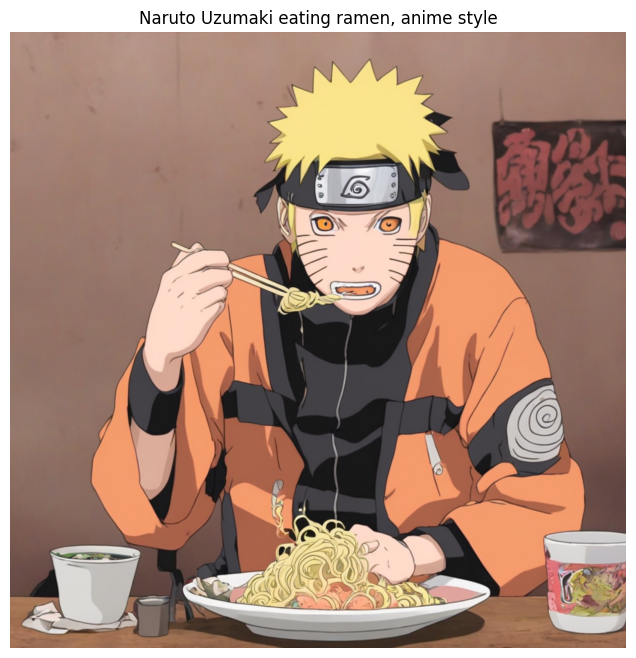


Generating: Bill Gates in Naruto anime style


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Saved: /content/drive/MyDrive/sdxl-naruto-lora/test_1.png


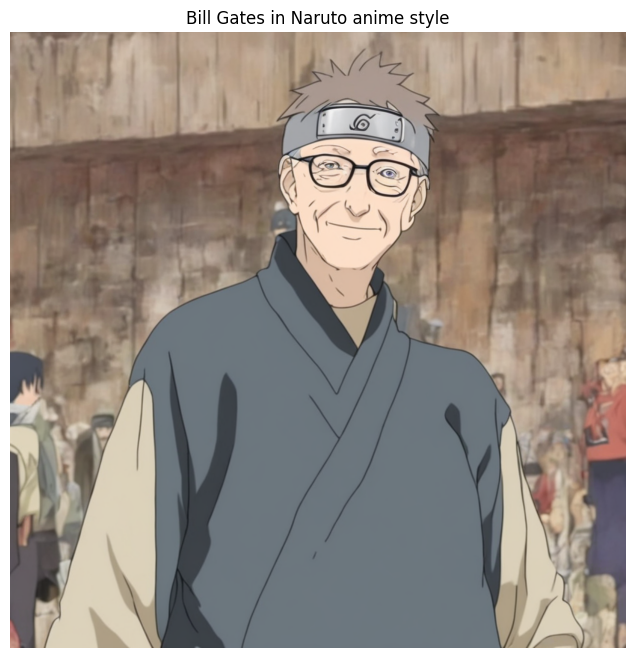


Generating: A boy with blue eyes in Naruto style


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Saved: /content/drive/MyDrive/sdxl-naruto-lora/test_2.png


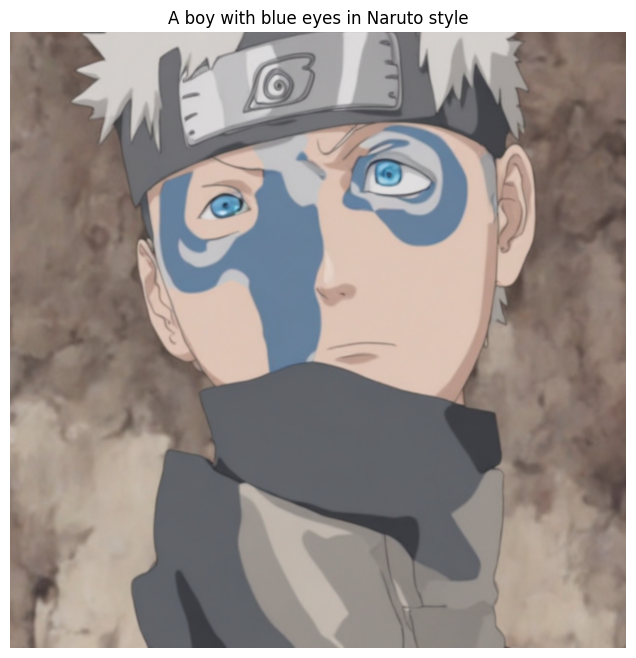

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

prompts = [
    "Naruto Uzumaki eating ramen, anime style",
    "Bill Gates in Naruto anime style",
    "A boy with blue eyes in Naruto style",
]

print("Generating images...")

for i, prompt in enumerate(prompts):
    print(f"\nGenerating: {prompt}")

    # Generate image
    image = pipeline(
        prompt,
        num_inference_steps=30,
        guidance_scale=7.5,
        generator=torch.Generator("cuda").manual_seed(42)
    ).images[0]

    # Save
    output_path = f"{config.output_dir}/test_{i}.png"
    image.save(output_path)
    print(f"✓ Saved: {output_path}")

    # Display
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(prompt)
    plt.show()


### 9.3 Compare with Base Model


In [ ]:
print("Loading base SDXL for comparison...")

base_pipeline = StableDiffusionXLPipeline.from_pretrained(
    config.model_id,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
).to("cuda")

prompt = "Naruto Uzumaki eating ramen, anime style"

# Generate with base model
print("\nGenerating with BASE model...")
base_image = base_pipeline(
    prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=torch.Generator("cuda").manual_seed(42)
).images[0]

# Generate with fine-tuned model
print("Generating with FINE-TUNED model...")
ft_image = pipeline(
    prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=torch.Generator("cuda").manual_seed(42)
).images[0]

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(base_image)
axes[0].set_title("Base SDXL", fontsize=16)
axes[0].axis("off")

axes[1].imshow(ft_image)
axes[1].set_title("Fine-tuned (Naruto Style)", fontsize=16)
axes[1].axis("off")

plt.tight_layout()
plt.show()

print(f"\n✓ Comparison complete!")
print(f"  Notice how the fine-tuned model captures Naruto's art style!")


Loading base SDXL for comparison...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 72889 has 14.73 GiB memory in use. Of the allocated memory 14.13 GiB is allocated by PyTorch, and 467.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Loading images from base model seperately

In [ ]:
from diffusers import DiffusionPipeline
import torch
import os

# List of prompts
prompts = [
    "Naruto Uzumaki eating ramen, anime style",
    "Bill Gates in Naruto anime style",
    "A boy with blue eyes in Naruto style",
]

# Create output folder
os.makedirs("outputs", exist_ok=True)

# Load SDXL Base
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
)

pipe.to("cuda")

# Enable xformers for lower VRAM (optional)
try:
    pipe.enable_xformers_memory_efficient_attention()
except Exception as e:
    print("Could not enable xformers:", e)

# Generate and save images
for i, prompt in enumerate(prompts, start=1):
    print(f"Generating image for prompt {i}: {prompt}")

    image = pipe(prompt=prompt).images[0]

    save_path = f"outputs/image_{i}.png"
    image.save(save_path)
    print(f"Saved: {save_path}")

print("Done!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.fp16.saf(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Could not enable xformers: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers
Generating image for prompt 1: Naruto Uzumaki eating ramen, anime style


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: outputs/image_1.png
Generating image for prompt 2: Bill Gates in Naruto anime style


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: outputs/image_2.png
Generating image for prompt 3: A boy with blue eyes in Naruto style


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: outputs/image_3.png
Done!


### 9.3 Compare with Base Model


Found images: ['image_1.png', 'image_2.png', 'image_3.png']


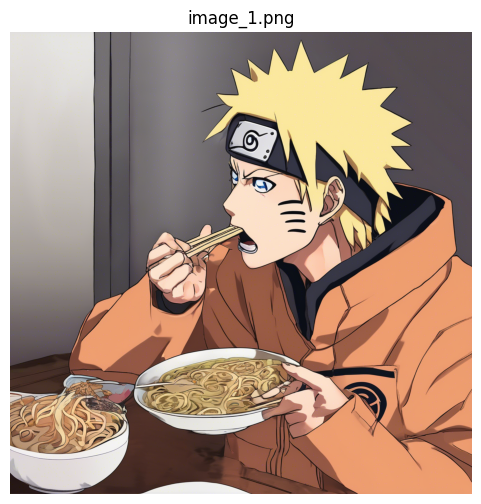

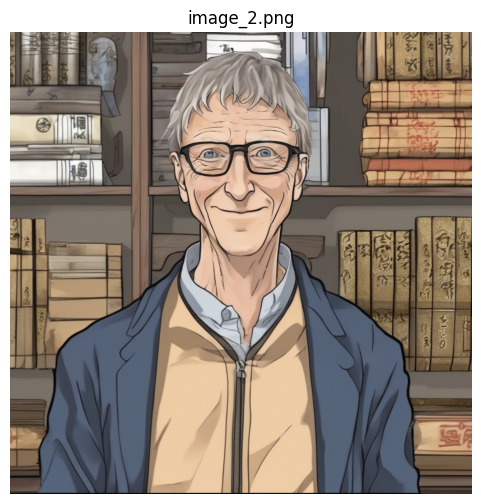

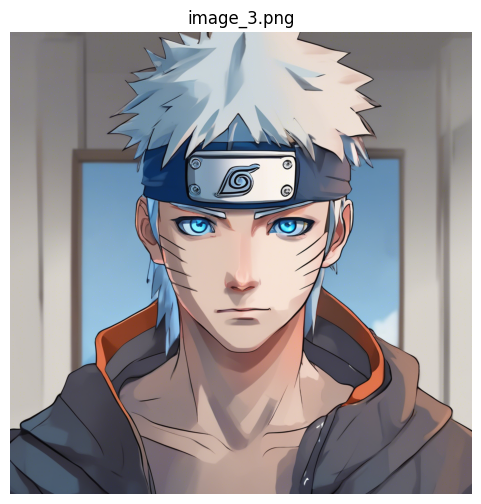

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

folder_path = "outputs"

image_files = sorted([
    f for f in os.listdir(folder_path)
    if f.lower().endswith((".png"))
])

print("Found images:", image_files)

for img_file in image_files:
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_file)
    plt.show()